In [2]:
# Sales Forecasting Model
# Predicting Total Sales for Next 30 Days

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)


# Loading and Preparing Data
# Load sales data
sales_path = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\data\cleaned_sales_data.csv"
df_sales = pd.read_csv(sales_path)

print(f"Sales data loaded: {df_sales.shape[0]:,} transactions")

# Convert date and handle missing values
df_sales['Date_of_Sale'] = pd.to_datetime(df_sales['Date_of_Sale'])
df_sales = df_sales.dropna(subset=['Sales_Amount', 'Date_of_Sale'])

print(f"After cleaning: {df_sales.shape[0]:,} transactions")
print(f"Date range: {df_sales['Date_of_Sale'].min().date()} to {df_sales['Date_of_Sale'].max().date()}")

# Creating Time Series Features

# Aggregate to daily level
daily_sales = df_sales.groupby(df_sales['Date_of_Sale'].dt.date).agg({
    'Sales_Amount': ['sum', 'count', 'mean', 'std'],
    'Discount': ['sum', 'mean']
}).reset_index()

daily_sales.columns = ['Date', 'Total_Sales', 'Num_Transactions', 'Avg_Transaction', 
                       'Std_Transaction', 'Total_Discount', 'Avg_Discount']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
daily_sales = daily_sales.sort_values('Date').reset_index(drop=True)

# Fill missing dates (if any)
date_range = pd.date_range(start=daily_sales['Date'].min(), end=daily_sales['Date'].max(), freq='D')
daily_sales = daily_sales.set_index('Date').reindex(date_range).reset_index()
daily_sales.columns = ['Date'] + list(daily_sales.columns[1:])

# Forward fill missing values
daily_sales = daily_sales.fillna(method='ffill')

print(f"Daily time-series created: {len(daily_sales)} days")
print(f"Features: {list(daily_sales.columns)}")

# Feature Engineering for ML Model
# Create a copy for feature engineering
df = daily_sales.copy()

# Temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['DayOfYear'] = df['Date'].dt.dayofyear
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)

# Lag features (past sales)
for lag in [1, 2, 3, 7, 14, 21, 28]:
    df[f'Sales_Lag_{lag}'] = df['Total_Sales'].shift(lag)

# Rolling statistics
for window in [7, 14, 28]:
    df[f'Sales_RollingMean_{window}'] = df['Total_Sales'].shift(1).rolling(window=window).mean()
    df[f'Sales_RollingStd_{window}'] = df['Total_Sales'].shift(1).rolling(window=window).std()
    df[f'Sales_RollingMin_{window}'] = df['Total_Sales'].shift(1).rolling(window=window).min()
    df[f'Sales_RollingMax_{window}'] = df['Total_Sales'].shift(1).rolling(window=window).max()

# Exponentially weighted moving average
df['Sales_EWMA_7'] = df['Total_Sales'].shift(1).ewm(span=7, adjust=False).mean()
df['Sales_EWMA_28'] = df['Total_Sales'].shift(1).ewm(span=28, adjust=False).mean()

# Trend features
df['Sales_Trend_7'] = df['Total_Sales'].shift(1) - df['Total_Sales'].shift(8)
df['Sales_Trend_28'] = df['Total_Sales'].shift(1) - df['Total_Sales'].shift(29)

# Transaction features
df['Transactions_Lag_7'] = df['Num_Transactions'].shift(7)
df['AvgTransaction_RollingMean_7'] = df['Avg_Transaction'].shift(1).rolling(window=7).mean()

# Discount features
df['Discount_RollingMean_7'] = df['Total_Discount'].shift(1).rolling(window=7).mean()

# Cyclical encoding for day of week and month
df['DayOfWeek_Sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_Cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

print(f"Feature engineering complete!")
print(f"Total features created: {len(df.columns)}")

# Drop rows with NaN (due to lag/rolling features)
df = df.dropna()
print(f"Dataset after removing NaN: {len(df)} rows")

display(df.head())

# Preparing Features and Target 
# Define target
target = 'Total_Sales'

# Define features (exclude date and target)
feature_cols = [col for col in df.columns if col not in ['Date', 'Total_Sales', 'Num_Transactions', 
                                                          'Avg_Transaction', 'Std_Transaction',
                                                          'Total_Discount', 'Avg_Discount']]

X = df[feature_cols]
y = df[target]

print(f"Features: {len(feature_cols)}")
print(f"Target: {target}")
print(f"Dataset size: {len(X)} samples")

print("Top 20 Features:")
for i, col in enumerate(feature_cols[:20], 1):
    print(f"  {i}. {col}")

# Train and Test Split

# Use 80% for training, 20% for testing 
split_idx = int(len(X) * 0.8)

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]
dates_train = df['Date'][:split_idx]
dates_test = df['Date'][split_idx:]

# Linea Regression Model 

from sklearn.linear_model import LinearRegression

print("Training Linear Regression")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# Metrics
lr_train_mae = mean_absolute_error(y_train, lr_train_pred)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, lr_train_pred))
lr_train_r2 = r2_score(y_train, lr_train_pred)

lr_test_mae = mean_absolute_error(y_test, lr_test_pred)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))
lr_test_r2 = r2_score(y_test, lr_test_pred)
lr_test_mape = np.mean(np.abs((y_test - lr_test_pred) / y_test)) * 100

print(f"Linear Regression Results:")
print(f"  Training   - MAE: ${lr_train_mae:,.2f}, RMSE: ${lr_train_rmse:,.2f}, R²: {lr_train_r2:.4f}")
print(f"  Test       - MAE: ${lr_test_mae:,.2f}, RMSE: ${lr_test_rmse:,.2f}, R²: {lr_test_r2:.4f}, MAPE: {lr_test_mape:.2f}%")

# Random Forest Model 
from sklearn.ensemble import RandomForestRegressor

print("Training Random Forest")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Metrics
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_train_r2 = r2_score(y_train, rf_train_pred)

rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_test_mape = np.mean(np.abs((y_test - rf_test_pred) / y_test)) * 100

print(f" Random Forest Results:")
print(f"  Training   - MAE: ${rf_train_mae:,.2f}, RMSE: ${rf_train_rmse:,.2f}, R²: {rf_train_r2:.4f}")
print(f"  Test       - MAE: ${rf_test_mae:,.2f}, RMSE: ${rf_test_rmse:,.2f}, R²: {rf_test_r2:.4f}, MAPE: {rf_test_mape:.2f}%")

# XGBOOST Model

try:
    import xgboost as xgb
    
    print("Training XGBoost")
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    
    # Predictions
    xgb_train_pred = xgb_model.predict(X_train)
    xgb_test_pred = xgb_model.predict(X_test)
    
    # Metrics
    xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
    xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_pred))
    xgb_train_r2 = r2_score(y_train, xgb_train_pred)
    
    xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
    xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))
    xgb_test_r2 = r2_score(y_test, xgb_test_pred)
    xgb_test_mape = np.mean(np.abs((y_test - xgb_test_pred) / y_test)) * 100
    
    print(f"XGBoost Results:")
    print(f"  Training   - MAE: ${xgb_train_mae:,.2f}, RMSE: ${xgb_train_rmse:,.2f}, R²: {xgb_train_r2:.4f}")
    print(f"  Test       - MAE: ${xgb_test_mae:,.2f}, RMSE: ${xgb_test_rmse:,.2f}, R²: {xgb_test_r2:.4f}, MAPE: {xgb_test_mape:.2f}%")
    
    xgb_available = True
    
except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")
    xgb_available = False

Sales data loaded: 100,000 transactions
After cleaning: 100,000 transactions
Date range: 2024-01-01 to 2024-09-10
Daily time-series created: 254 days
Features: ['Date', 'Total_Sales', 'Num_Transactions', 'Avg_Transaction', 'Std_Transaction', 'Total_Discount', 'Avg_Discount']
Feature engineering complete!
Total features created: 47
Dataset after removing NaN: 225 rows


,Date,Total_Sales,Num_Transactions,Avg_Transaction,Std_Transaction,Total_Discount,Avg_Discount,Year,Month,Day,...,Sales_EWMA_28,Sales_Trend_7,Sales_Trend_28,Transactions_Lag_7,AvgTransaction_RollingMean_7,Discount_RollingMean_7,DayOfWeek_Sin,DayOfWeek_Cos,Month_Sin,Month_Cos
29,2024-01-30,210252.560,382,550.399372,244.602493,9587.33,25.097723,2024,1,30,...,212413.190105,6852.995,-11879.655,398.0,547.827422,9619.718571,0.781831,0.623490,0.500000,0.866025
30,2024-01-31,219148.855,401,546.505873,241.565776,9517.51,23.734439,2024,1,31,...,212264.181132,-7018.360,-17522.755,389.0,548.469213,9529.480000,0.974928,-0.222521,0.500000,0.866025
31,2024-02-01,215243.460,386,557.625544,241.877990,9431.51,24.433964,2024,2,1,...,212738.986226,8861.560,12042.370,389.0,549.315152,9519.022857,0.433884,-0.900969,0.866025,0.500000
32,2024-02-02,215565.885,394,547.121536,251.559613,9906.42,25.143198,2024,2,2,...,212911.708555,8810.800,27838.990,357.0,553.165198,9455.624286,-0.433884,-0.900969,0.866025,0.500000
33,2024-02-03,200731.535,372,539.600901,250.172068,9276.67,24.937285,2024,2,3,...,213094.755207,14622.860,-3772.240,370.0,550.916044,9560.568571,-0.974928,-0.222521,0.866025,0.500000


Features: 40
Target: Total_Sales
Dataset size: 225 samples
Top 20 Features:
  1. Year
  2. Month
  3. Day
  4. DayOfWeek
  5. DayOfYear
  6. WeekOfYear
  7. Quarter
  8. IsWeekend
  9. IsMonthStart
  10. IsMonthEnd
  11. Sales_Lag_1
  12. Sales_Lag_2
  13. Sales_Lag_3
  14. Sales_Lag_7
  15. Sales_Lag_14
  16. Sales_Lag_21
  17. Sales_Lag_28
  18. Sales_RollingMean_7
  19. Sales_RollingStd_7
  20. Sales_RollingMin_7
Training Linear Regression
Linear Regression Results:
  Training   - MAE: $7,963.28, RMSE: $9,716.05, R²: 0.2411
  Test       - MAE: $12,358.02, RMSE: $15,648.22, R²: -0.6013, MAPE: 5.88%
Training Random Forest
 Random Forest Results:
  Training   - MAE: $3,305.48, RMSE: $4,141.12, R²: 0.8621
  Test       - MAE: $10,310.56, RMSE: $12,208.81, R²: 0.0253, MAPE: 4.76%
Training XGBoost
XGBoost Results:
  Training   - MAE: $92.81, RMSE: $132.94, R²: 0.9999
  Test       - MAE: $10,466.51, RMSE: $12,553.83, R²: -0.0306, MAPE: 4.85%


Model Performance Comparison (sorted by MAPE):
----------------------------------------------------------------------------------------------------


,Model,Test_MAE,Test_RMSE,Test_R2,Test_MAPE
1,Random Forest,10310.557844,12208.811317,0.025286,4.762963
2,XGBoost,10466.506097,12553.826937,-0.030582,4.850420
0,Linear Regression,12358.017664,15648.222837,-0.601254,5.878618


Best Model: Random Forest (MAPE: 4.76%)

Top 20 Most Important Features:
----------------------------------------------------------------------------------------------------


,Feature,Importance
22,Sales_RollingStd_14,0.098709
11,Sales_Lag_2,0.089736
12,Sales_Lag_3,0.056459
16,Sales_Lag_28,0.054204
35,Discount_RollingMean_7,0.049927
34,AvgTransaction_RollingMean_7,0.048903
15,Sales_Lag_21,0.045535
31,Sales_Trend_7,0.043816
14,Sales_Lag_14,0.043345
32,Sales_Trend_28,0.035847


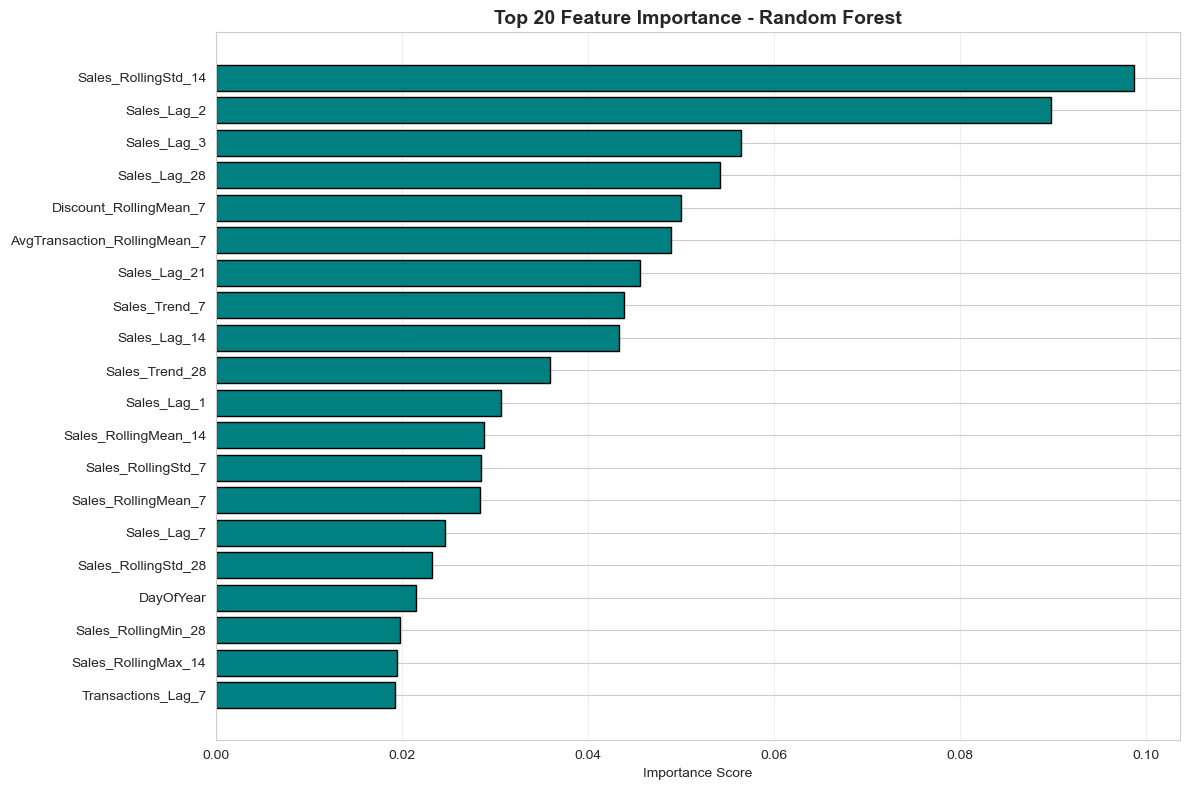

In [3]:
# Model Comparison 

# Create comparison dataframe
comparison_data = {
    'Model': ['Linear Regression', 'Random Forest'],
    'Test_MAE': [lr_test_mae, rf_test_mae],
    'Test_RMSE': [lr_test_rmse, rf_test_rmse],
    'Test_R2': [lr_test_r2, rf_test_r2],
    'Test_MAPE': [lr_test_mape, rf_test_mape]
}

if xgb_available:
    comparison_data['Model'].append('XGBoost')
    comparison_data['Test_MAE'].append(xgb_test_mae)
    comparison_data['Test_RMSE'].append(xgb_test_rmse)
    comparison_data['Test_R2'].append(xgb_test_r2)
    comparison_data['Test_MAPE'].append(xgb_test_mape)

comparison_df = pd.DataFrame(comparison_data).sort_values('Test_MAPE')

print("Model Performance Comparison (sorted by MAPE):")
print("-" * 100)
display(comparison_df)

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"Best Model: {best_model_name} (MAPE: {comparison_df.iloc[0]['Test_MAPE']:.2f}%)")

# Get best model predictions
if best_model_name == 'XGBoost':
    best_model = xgb_model
    best_test_pred = xgb_test_pred
elif best_model_name == 'Random Forest':
    best_model = rf_model
    best_test_pred = rf_test_pred
else:
    best_model = lr_model
    best_test_pred = lr_test_pred

# Feature Importance

if best_model_name in ['Random Forest', 'XGBoost']:
    # Get feature importance
    if best_model_name == 'XGBoost':
        importance = best_model.feature_importances_
    else:
        importance = best_model.feature_importances_
    
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print("-" * 100)
    display(feature_importance.head(20))
    
    # Visualization
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'].values, color='teal', edgecolor='black')
    plt.yticks(range(len(top_features)), top_features['Feature'].values)
    plt.xlabel('Importance Score')
    plt.title(f'Top 20 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

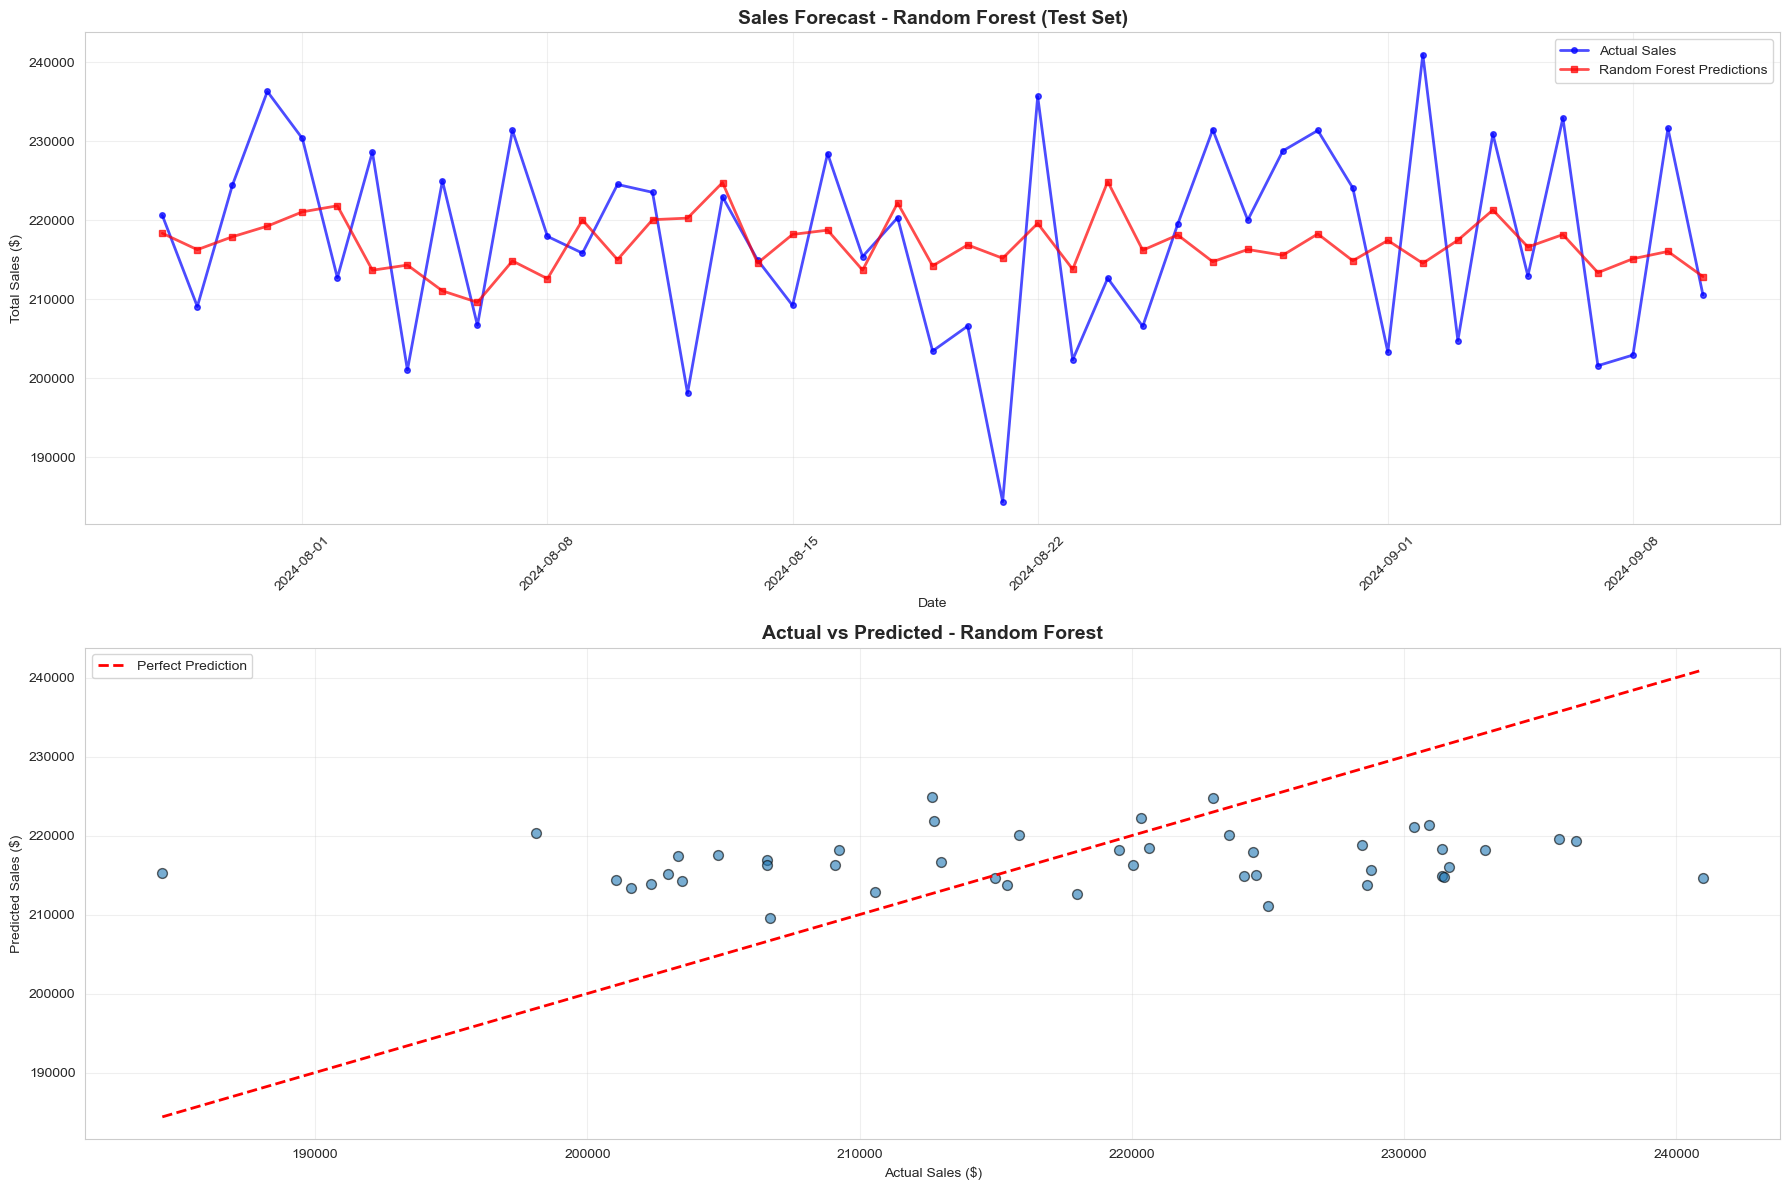

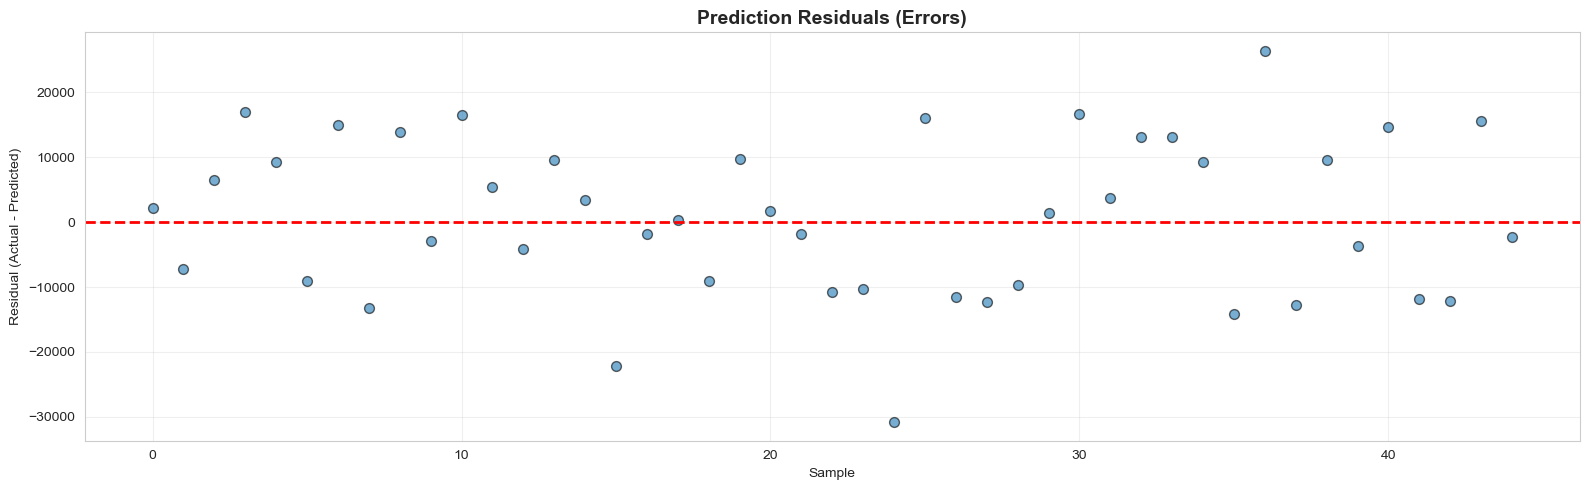

In [4]:
# Prediction Visualization

# Plot actual vs predicted
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Test set predictions
axes[0].plot(dates_test.values, y_test.values, color='blue', linewidth=2, 
            marker='o', markersize=4, label='Actual Sales', alpha=0.7)
axes[0].plot(dates_test.values, best_test_pred, color='red', linewidth=2, 
            marker='s', markersize=4, label=f'{best_model_name} Predictions', alpha=0.7)
axes[0].set_title(f'Sales Forecast - {best_model_name} (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Sales ($)')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Scatter plot: Actual vs Predicted
axes[1].scatter(y_test, best_test_pred, alpha=0.6, edgecolors='black', s=50)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title(f'Actual vs Predicted - {best_model_name}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Sales ($)')
axes[1].set_ylabel('Predicted Sales ($)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test - best_test_pred

plt.figure(figsize=(16, 5))
plt.scatter(range(len(residuals)), residuals, alpha=0.6, edgecolors='black', s=50)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Prediction Residuals (Errors)', fontsize=14, fontweight='bold')
plt.xlabel('Sample')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# Forecast next 30 Days

print("Generating 30-day forecast")

# Start from the last date in dataset
last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30, freq='D')

# Create future dataframe with same features
future_predictions = []
current_df = df.copy()

for future_date in future_dates:
    # Create new row with temporal features
    new_row = pd.Series(index=df.columns)
    new_row['Date'] = future_date
    new_row['Year'] = future_date.year
    new_row['Month'] = future_date.month
    new_row['Day'] = future_date.day
    new_row['DayOfWeek'] = future_date.dayofweek
    new_row['DayOfYear'] = future_date.dayofyear
    new_row['WeekOfYear'] = future_date.isocalendar()[1]
    new_row['Quarter'] = (future_date.month - 1) // 3 + 1
    new_row['IsWeekend'] = 1 if future_date.dayofweek >= 5 else 0
    new_row['IsMonthStart'] = 1 if future_date.day == 1 else 0
    new_row['IsMonthEnd'] = 1 if future_date.day == pd.Timestamp(future_date).days_in_month else 0
    
    # Cyclical encoding
    new_row['DayOfWeek_Sin'] = np.sin(2 * np.pi * new_row['DayOfWeek'] / 7)
    new_row['DayOfWeek_Cos'] = np.cos(2 * np.pi * new_row['DayOfWeek'] / 7)
    new_row['Month_Sin'] = np.sin(2 * np.pi * new_row['Month'] / 12)
    new_row['Month_Cos'] = np.cos(2 * np.pi * new_row['Month'] / 12)
    
    # Lag features from historical data
    for lag in [1, 2, 3, 7, 14, 21, 28]:
        if lag <= len(current_df):
            new_row[f'Sales_Lag_{lag}'] = current_df['Total_Sales'].iloc[-lag]
    
    # Rolling features
    for window in [7, 14, 28]:
        if window <= len(current_df):
            new_row[f'Sales_RollingMean_{window}'] = current_df['Total_Sales'].iloc[-window:].mean()
            new_row[f'Sales_RollingStd_{window}'] = current_df['Total_Sales'].iloc[-window:].std()
            new_row[f'Sales_RollingMin_{window}'] = current_df['Total_Sales'].iloc[-window:].min()
            new_row[f'Sales_RollingMax_{window}'] = current_df['Total_Sales'].iloc[-window:].max()
    
    # EWMA features
    new_row['Sales_EWMA_7'] = current_df['Total_Sales'].ewm(span=7, adjust=False).mean().iloc[-1]
    new_row['Sales_EWMA_28'] = current_df['Total_Sales'].ewm(span=28, adjust=False).mean().iloc[-1]
    
    # Trend features
    if len(current_df) >= 8:
        new_row['Sales_Trend_7'] = current_df['Total_Sales'].iloc[-1] - current_df['Total_Sales'].iloc[-8]
    if len(current_df) >= 29:
        new_row['Sales_Trend_28'] = current_df['Total_Sales'].iloc[-1] - current_df['Total_Sales'].iloc[-29]
    
    # Filling remaining features with recent averages
    for col in feature_cols:
        if pd.isna(new_row[col]) and col in current_df.columns:
            new_row[col] = current_df[col].tail(7).mean()
    
    # Making prediction
    X_future = new_row[feature_cols].values.reshape(1, -1)
    prediction = best_model.predict(X_future)[0]
    
    future_predictions.append(prediction)
    
    # Update current_df with prediction for next iteration
    new_row['Total_Sales'] = prediction
    current_df = pd.concat([current_df, new_row.to_frame().T], ignore_index=True)

# Creating future forecast dataframe
future_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Sales': future_predictions
})


print(f"Forecast Period: {future_df['Date'].min().date()} to {future_df['Date'].max().date()}")
print(f"Total Forecasted Revenue: ${future_df['Forecasted_Sales'].sum():,.2f}")
print(f"Average Daily Forecast: ${future_df['Forecasted_Sales'].mean():,.2f}")

# Display forecast
print("\nForecast Summary:")
print("-" * 100)
display(future_df.head(10))

Generating 30-day forecast
Forecast Period: 2024-09-11 to 2024-10-10
Total Forecasted Revenue: $6,292,107.25
Average Daily Forecast: $209,736.91

Forecast Summary:
----------------------------------------------------------------------------------------------------


,Date,Forecasted_Sales
0,2024-09-11,219103.525093
1,2024-09-12,217718.509190
2,2024-09-13,215880.604910
3,2024-09-14,216836.497780
4,2024-09-15,217071.855312
5,2024-09-16,223168.660250
6,2024-09-17,218322.113165
7,2024-09-18,221501.801050
8,2024-09-19,217002.572044
9,2024-09-20,217976.192600


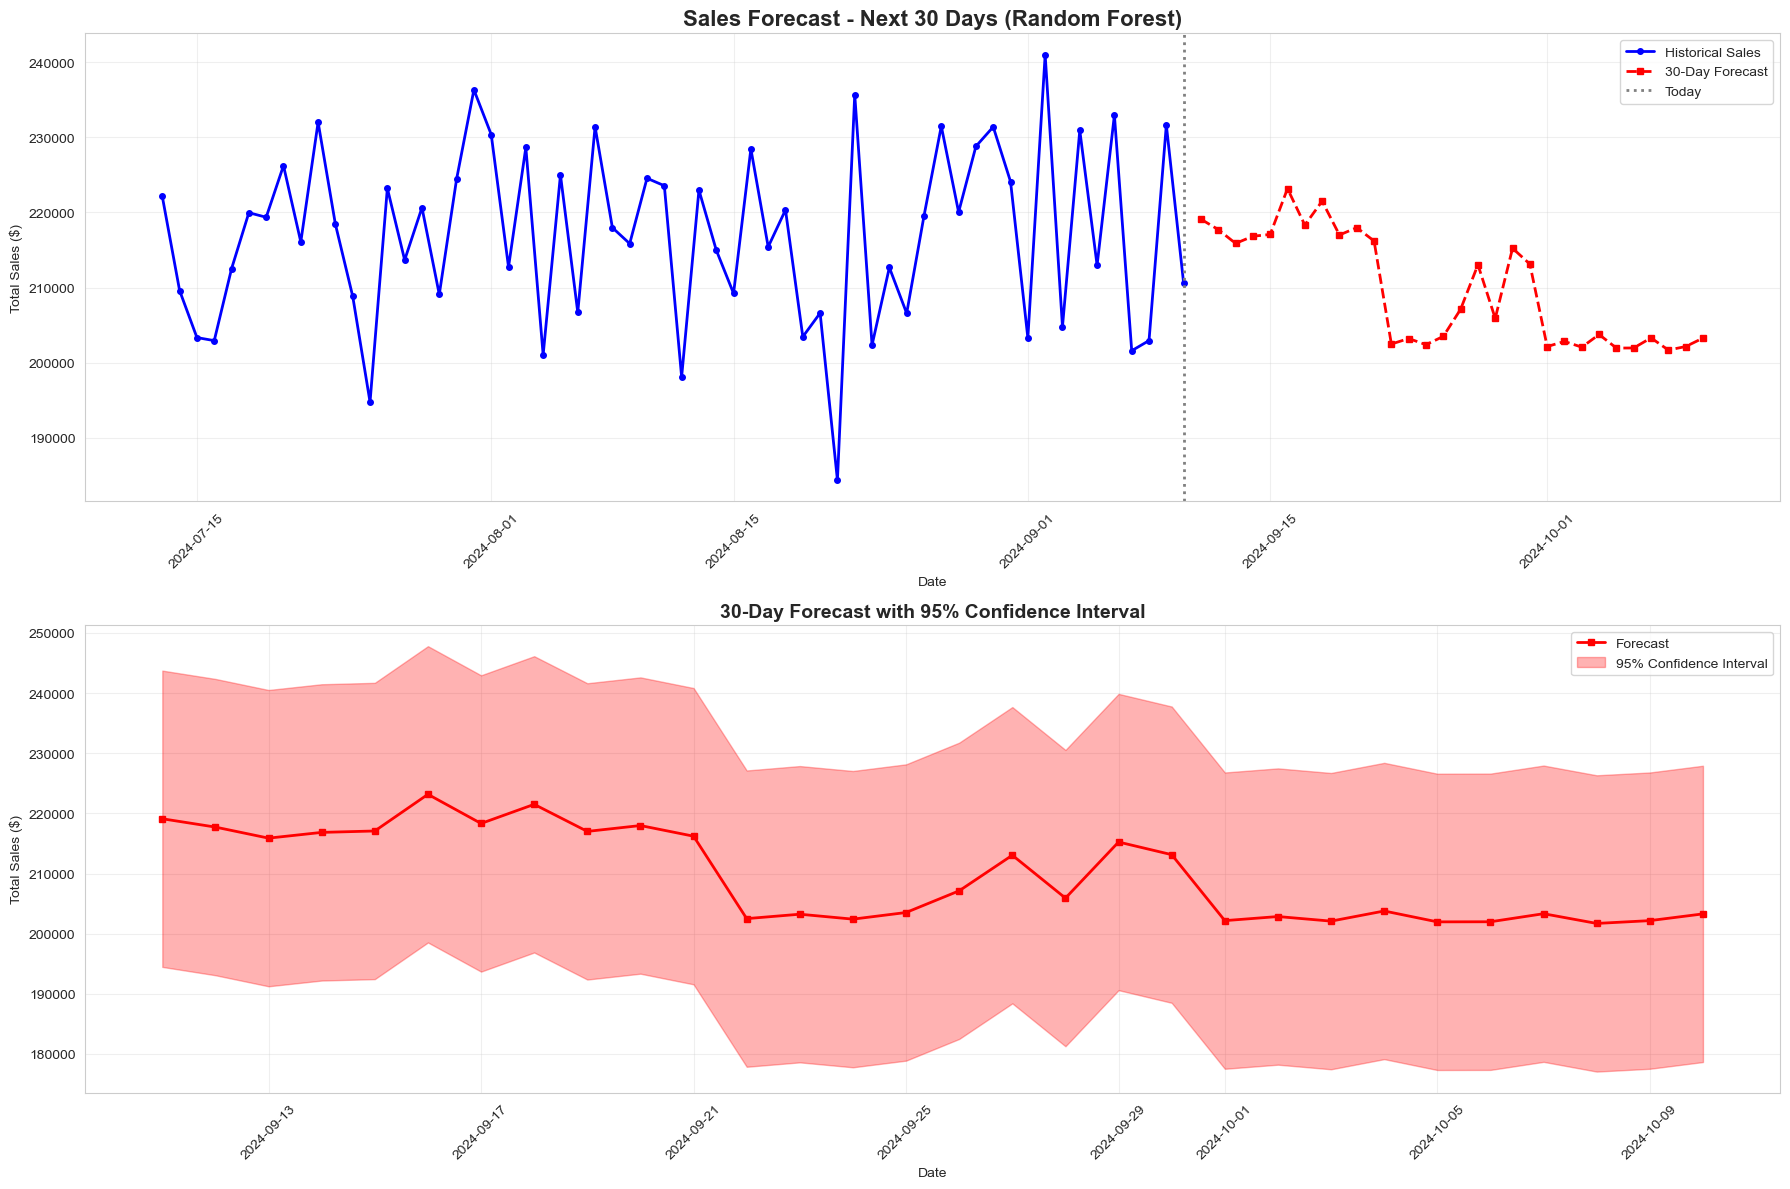


Weekly Forecast Breakdown:
----------------------------------------------------------------------------------------------------


,Week,Total_Forecasted_Sales
0,37,1.086611e+06
1,38,1.516672e+06
2,39,1.450459e+06
3,40,1.427912e+06
4,41,8.104530e+05


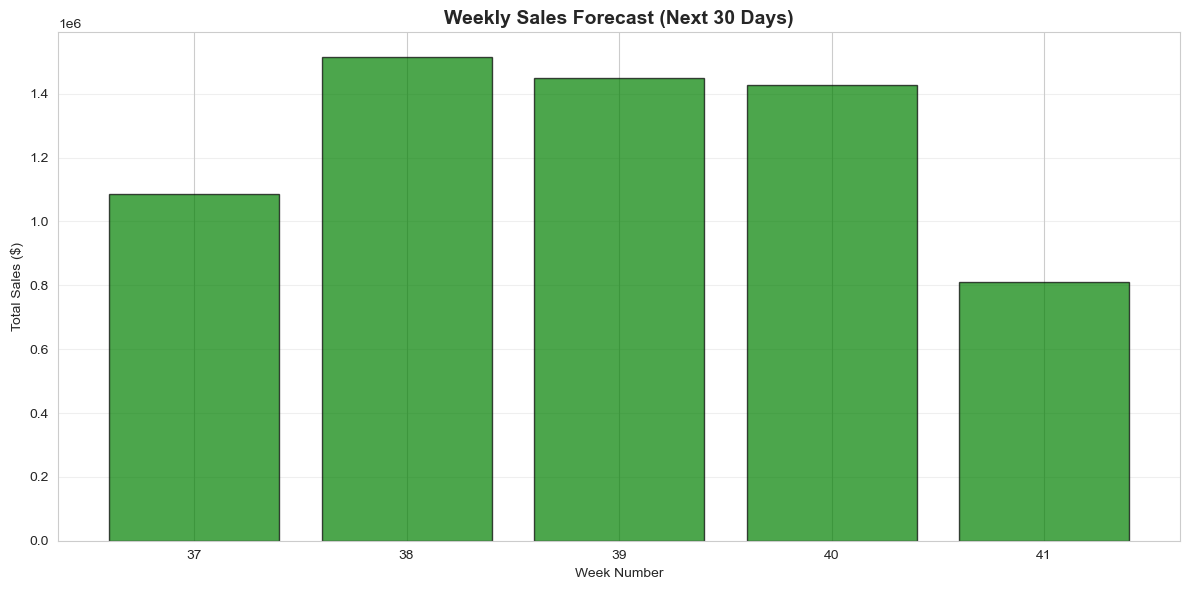

In [6]:
# Future Forecast Visualization 

# Plot historical + forecast
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Last 60 days + 30 day forecast
last_60_days = df.tail(60)

axes[0].plot(last_60_days['Date'], last_60_days['Total_Sales'], 
            color='blue', linewidth=2, marker='o', markersize=4, label='Historical Sales')
axes[0].plot(future_df['Date'], future_df['Forecasted_Sales'], 
            color='red', linewidth=2, marker='s', markersize=5, label='30-Day Forecast', linestyle='--')
axes[0].axvline(x=last_date, color='gray', linestyle=':', linewidth=2, label='Today')
axes[0].set_title(f'Sales Forecast - Next 30 Days ({best_model_name})', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Sales ($)')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Forecast with confidence interval
std_dev = residuals.std()
axes[1].plot(future_df['Date'], future_df['Forecasted_Sales'], 
            color='red', linewidth=2, marker='s', markersize=5, label='Forecast')
axes[1].fill_between(future_df['Date'], 
                     future_df['Forecasted_Sales'] - 2*std_dev,
                     future_df['Forecasted_Sales'] + 2*std_dev,
                     alpha=0.3, color='red', label='95% Confidence Interval')
axes[1].set_title('30-Day Forecast with 95% Confidence Interval', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Sales ($)')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Weekly forecast breakdown
future_df['Week'] = future_df['Date'].dt.isocalendar().week
weekly_forecast = future_df.groupby('Week')['Forecasted_Sales'].sum().reset_index()
weekly_forecast.columns = ['Week', 'Total_Forecasted_Sales']

print("\nWeekly Forecast Breakdown:")
print("-" * 100)
display(weekly_forecast)

plt.figure(figsize=(12, 6))
plt.bar(weekly_forecast['Week'], weekly_forecast['Total_Forecasted_Sales'], 
       color='green', edgecolor='black', alpha=0.7)
plt.title('Weekly Sales Forecast (Next 30 Days)', fontsize=14, fontweight='bold')
plt.xlabel('Week Number')
plt.ylabel('Total Sales ($)')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [7]:
# Save Results

# Save model comparison
comparison_output = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\sales_model_comparison.csv"
comparison_df.to_csv(comparison_output, index=False)
print(f"Model comparison saved to: {comparison_output}")

# Save test predictions
test_results = pd.DataFrame({
    'Date': dates_test.values,
    'Actual_Sales': y_test.values,
    'Predicted_Sales': best_test_pred,
    'Error': residuals.values
})
test_output = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\sales_test_predictions.csv"
test_results.to_csv(test_output, index=False)
print(f"Test predictions saved to: {test_output}")

# Save 30-day forecast
forecast_output = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\sales_forecast_30days.csv"
future_df.to_csv(forecast_output, index=False)
print(f"30-day forecast saved to: {forecast_output}")

# Save feature importance
if best_model_name in ['Random Forest', 'XGBoost']:
    importance_output = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\feature_importance.csv"
    feature_importance.to_csv(importance_output, index=False)
    print(f"Feature importance saved to: {importance_output}")

# Save the model
import pickle
model_output = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\best_sales_model.pkl"
with open(model_output, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Best model saved to: {model_output}")

Model comparison saved to: C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\sales_model_comparison.csv
Test predictions saved to: C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\sales_test_predictions.csv
30-day forecast saved to: C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\sales_forecast_30days.csv
Feature importance saved to: C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\feature_importance.csv
Best model saved to: C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\best_sales_model.pkl


In [10]:
# Conclusion

print("""
Conclusion Summary

1. Distinct purchasing patterns were identified within the e-commerce customer base.

2. Spending behaviour is primarily driven by engagement patterns such as:
   - Purchase frequency
   - Basket size
   - Recent transaction value

3. Demographic factors showed minimal influence on spending behaviour:
   - Age
   - Income

4. Unsupervised clustering revealed four meaningful customer personas:
   - Loyal regular shoppers who provide consistent revenue
   - Occasional high-ticket buyers who contribute significant value per transaction
   - Newly engaged high-frequency customers with strong growth potential
   - High-income customers with low engagement and potential churn risk

5. Revenue analysis highlighted which customer segments generate the highest business value.

6. Time-series feature engineering enabled effective sales forecasting, transforming descriptive insights into predictive capability.

Overall, this project integrates customer behaviour analytics, machine learning-based segmentation, and predictive modelling to:
   - Optimise revenue growth
   - Enhance long-term customer value
   - Support data-driven marketing strategies in an e-commerce environment
""")


Conclusion Summary

1. Distinct purchasing patterns were identified within the e-commerce customer base.

2. Spending behaviour is primarily driven by engagement patterns such as:
   - Purchase frequency
   - Basket size
   - Recent transaction value

3. Demographic factors showed minimal influence on spending behaviour:
   - Age
   - Income

4. Unsupervised clustering revealed four meaningful customer personas:
   - Loyal regular shoppers who provide consistent revenue
   - Occasional high-ticket buyers who contribute significant value per transaction
   - Newly engaged high-frequency customers with strong growth potential
   - High-income customers with low engagement and potential churn risk

5. Revenue analysis highlighted which customer segments generate the highest business value.

6. Time-series feature engineering enabled effective sales forecasting, transforming descriptive insights into predictive capability.

Overall, this project integrates customer behaviour analytics, ma